# EPIG Figure 1

In [ ]:
!conda install -y -c anaconda scikit-learn

Solving environment: done

# All requested packages already installed.



In [ ]:
import itertools

import numpy as np
from scipy.stats import multivariate_normal, norm
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.model_selection import train_test_split

In [ ]:
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
def sample(x, f, noise_f):
    y = f(x)
    stddev_x = noise_f(x)
    noise = np.random.normal(0, stddev_x)
    y += noise

    return y, stddev_x


def sample_and_fit_gp(x, f, noise_f):
    y, stddev_x = sample(x, f, noise_f)
    gp = fit_gp(x, y, stddev_x)

    return gp, y, stddev_x


def fit_gp(x, y, std):
    x = np.asarray(x)
    y = np.asarray(y)
    std = np.asarray(std)

    #kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
    kernel = RBF(1, (1e-2, 1e2))
    # kernel = RBF(0.1, (1e-2, 1e2))
    # Instantiate a Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel, alpha=std ** 2, n_restarts_optimizer=10)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(x[:, None], y)

    return gp

In [ ]:
def plot_stddev(x, y, sigma, axes=None, color="b", label="95% confidence interval"):
    if axes is None:
        axes = plt.gca()

    axes.fill(
        np.concatenate([x, x[::-1]]),
        np.concatenate([y - 1.9600 * sigma, (y + 1.9600 * sigma)[::-1]]),
        alpha=0.25,
        fc=color,
        ec="None",
        label=label,
    )

In [ ]:
def plot_gp(gp, obs_x, obs_y, obs_stddev, x_min=-5, x_max=5, axes=None, color="b", show_obs=True):
    if axes is None:
        axes = plt.gca()

    obs_x = np.asarray(obs_x)
    obs_y = np.asarray(obs_y)

    # x_min = obs_x.min() - padding
    # x_max = obs_x.max() + padding

    axes.set_xlim(x_min, x_max)

    x = np.linspace(x_min, x_max, 1000)
    y, sigma = gp.predict(x[:, None], return_std=True)

    if show_obs:
        axes.errorbar(obs_x, obs_y, obs_stddev, fmt="rx", markersize=10, label=u"Training Data")
    axes.plot(x, y, "-", color=color, label=u"Prediction")

    plot_stddev(x, y, sigma, color=color)

    return x, y, sigma

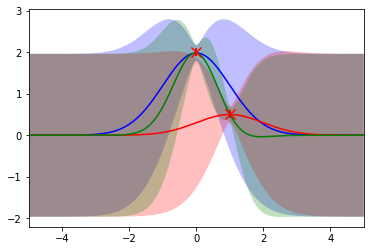

In [ ]:
x = [0.]
y = [2.]
stddev = 0.1
gp = fit_gp(
    x,
    y,
    stddev,
)

x_val = [1]*1
y_val = 0.5 + np.random.randn(1)*0.1
gp_val_only = fit_gp(x_val, y_val, stddev)
gp_val = fit_gp(np.concatenate([x, x_val]), np.concatenate([y, y_val]), stddev)

plot_gp(gp, x, y, stddev, color="blue")
plot_gp(gp_val_only, x_val, y_val, stddev, color="red")
plot_gp(gp_val, np.concatenate([x, x_val]), np.concatenate([y, y_val]), stddev, color="green")

plt.show()

In [ ]:
def BALD(gp: GaussianProcessRegressor, x, stddev):
    y_mean, y_stddev = gp.predict([[x]], return_std=True)

    bald_value = norm(scale=y_stddev+stddev).entropy() - norm(scale=stddev).entropy()
    
    return bald_value

In [ ]:
X = np.arange(-3, 3, 0.05)
Y = np.arange(-2.5, 3.5, 0.05)

In [ ]:
bald_scores = [BALD(gp, x, stddev) for x in X]

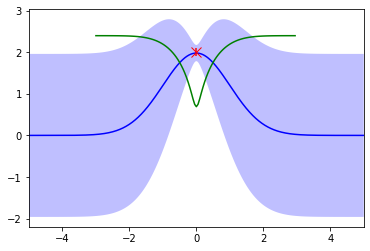

In [ ]:
plot_gp(gp, x, y, stddev)
plt.plot(X, bald_scores, c="g", label="BALD")

In [ ]:
def EPIG(gp: GaussianProcessRegressor, x, x_e, stddev):
    Y_mean, cov = gp.predict([[x], [x_e]], return_cov=True)

    cov += np.diag([stddev, stddev])

    H_Y = norm(scale=cov[0, 0] ** 0.5).entropy()
    H_Y_e = norm(scale=cov[1, 1] ** 0.5).entropy()

    H_Y__Y_e = multivariate_normal(Y_mean, cov=cov).entropy()

    # print(H_Y, H_Y_e, H_Y__Y_e)

    epig_value = H_Y + H_Y_e - H_Y__Y_e

    return epig_value

In [ ]:
x_e = -1
epig_scores = [EPIG(gp, x, x_e, stddev) for x in X]

In [ ]:
def PPIG(gp: GaussianProcessRegressor, gp_val: GaussianProcessRegressor, x, Y, stddev):
    y_mean, y_std = gp.predict([[x]], return_std=True)
    y_val_mean, y_val_std = gp_val.predict([[x]], return_std=True)

    y_std += stddev
    y_val_std += stddev
      
    ppig_values = -norm(y_mean, scale=y_std).logpdf(Y) + norm(y_val_mean, scale=y_val_std).logpdf(Y) 
    
    return ppig_values

In [ ]:
def PPIG_alternative(gp: GaussianProcessRegressor, x, Y, x_val, y_val, stddev):
    #print(x, x_val)
    Y_mean, y_cov = gp.predict([x, x_val], return_cov=True)
    
    y_cov += np.diag([stddev, stddev])
    
    H_Y = -norm(Y_mean[0], scale=y_cov[0, 0] ** 0.5).logpdf(Y)
    H_Y_val = -norm(Y_mean[1], scale=y_cov[1, 1] ** 0.5).logpdf(y_val[0])
    
    H_Y__Y_val = -multivariate_normal(Y_mean, cov=y_cov).logpdf([[y, y_val[0]] for y in Y])
          
    # -log p(y) + -log p(y_v) - -log p(y, y_v) = -log p(y) - (-log p(y, y_v) - -log p(y_v))
    # = -log p(y) - -log p(y | y_v)
    # = -log p(y_v) - -log p(y_v | y)
    ppig_values = H_Y + H_Y_val - H_Y__Y_val
    
    return ppig_values

In [ ]:
ppig_scores = [PPIG_alternative(gp, [x], Y, x_val, y_val, stddev) for x in X]
np.min(ppig_scores), np.max(ppig_scores)

(-20.501006800370252, 1.025563881132219)

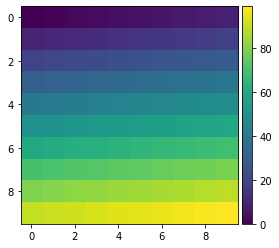

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

ax = plt.subplot()
im = ax.imshow(np.arange(100).reshape((10, 10)))

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


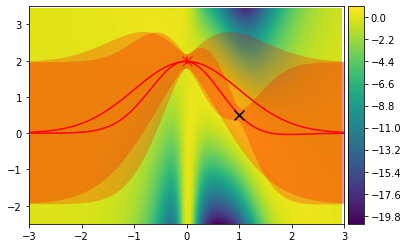

In [ ]:
ax = plt.subplot()

plot_gp(gp, x, y, stddev, color="red", axes=ax, x_min=-6, x_max=6)
plot_gp(gp_val, x+x_val, y+y_val, stddev, color="red", axes=ax, show_obs=False, x_min=-6, x_max=6)

ax.set_xlim([-3, 3])
ax.set_ylim([-2.5, 3.5])

c = ax.contourf(X, Y, np.transpose(np.asarray(ppig_scores)), cmap="viridis", levels=255)

ax.scatter(x_val, y_val, c="black", marker="x", s=100, label="Validation Data", zorder=6)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(c, cax=cax)

#ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.plot(X, epig_scores, c="r", linewidth=2, label="EPIG")
# plt.plot(X, bald_scores, c="g", linewidth=2, label="BALD")


# plt.vlines([x_e], ymin=-4, ymax=4, colors="black", label="Evaluation Point")
# handles, labels = plt.gca().get_legend_handles_labels()
# hl = list(zip(handles, labels))
# hl = [
#     hl[1],
#     hl[2],
# ]
# print(labels)


In [ ]:
ppig_approx_scores = [PPIG(gp, gp_val_only, x, Y, stddev) for x in X]
np.min(ppig_approx_scores), np.max(ppig_approx_scores)

(-104.69563940347474, 245.76935306232292)

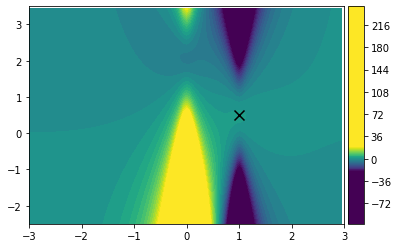

In [ ]:
ax = plt.subplot()

# plot_gp(gp, x, y, stddev, color="red", axes=ax, x_min=-6, x_max=6)
# plot_gp(gp_val,np.concatenate([x, x_val]), np.concatenate([y, y_val]), stddev, color="red", axes=ax, show_obs=False, x_min=-6, x_max=6)

ax.set_xlim([-3, 3])
ax.set_ylim([-2.5, 3.5])

c = ax.contourf(X, Y, np.transpose(np.asarray(ppig_approx_scores)), cmap="viridis", levels=255, vmin=-20, vmax=20)

ax.scatter(x_val, y_val, c="black", marker="x", s=100, label="Validation Data", zorder=6)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(c, cax=cax)

#ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# plt.plot(X, epig_scores, c="r", linewidth=2, label="EPIG")
# plt.plot(X, bald_scores, c="g", linewidth=2, label="BALD")


# plt.vlines([x_e], ymin=-4, ymax=4, colors="black", label="Evaluation Point")
# handles, labels = plt.gca().get_legend_handles_labels()
# hl = list(zip(handles, labels))
# hl = [
#     hl[1],
#     hl[2],
# ]
# print(labels)


['Prediction', 'EPIG', 'BALD', '95% confidence interval', 'Evaluation Point', 'Training Data']


(-2.5, 3.5)

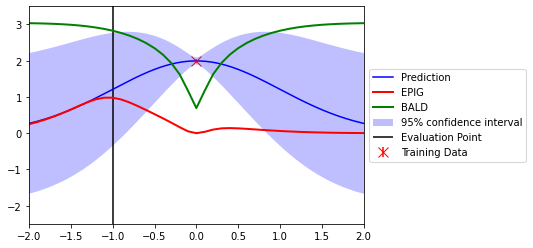

In [ ]:
plot_gp(gp, x, y, stddev)
plt.plot(X, epig_scores, c="r", linewidth=2, label="EPIG")
plt.plot(X, bald_scores, c="g", linewidth=2, label="BALD")
#plt.scatter([x_e], [0], c="black", marker="o")

plt.vlines([x_e], ymin=-4, ymax=4, colors="black", label="Evaluation Point")
handles, labels = plt.gca().get_legend_handles_labels()
hl = list(zip(handles, labels))
hl = [hl[1], hl[2], ]
print(labels)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim([-2, 2])
plt.ylim([-2.5, 3.5])